# Dose extraction

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


def bar_annotation(ax, option='number'):
    '''
    This function is to add according number or percentage on every bar
    option: number or percentage, default is number
    ax: the figure object
    '''
    try:
        if option == 'number':
            for i in ax.patches:
                ax1.text(i.get_x(), i.get_height()+.5, i.get_height(),
                         fontsize=15, color='dimgrey')
        if option == 'percentage':
            totals = []
            for i in ax.patches:
                totals.append(i.get_height())
                total = sum(totals)
            for i in ax.patches:
                ax.text(i.get_x(), i.get_height()+.5,
                        str(round((i.get_height()/total)*100, 2))+'%',
                        fontsize=15, color='dimgrey')
    except:
        return('inputs are wrong')


def total_seconds(time):
    '''
    Convert the resolution of time to hours
    '''
    return time.total_seconds()/3600


In [11]:
# -----------------------------------------------------------------------------------
# Load the medication tables
# -----------------------------------------------------------------------------------

pd.options.display.max_rows = 50
pd.options.display.max_columns = 10
root_dir = 'C:/Users/Administrator/Desktop/research//Hand_dirty/SAH_data/'
enc_med_cl2 = pd.read_csv(root_dir+'medication/sah_pts_enc_med_sl_ad_cl2.tsv',
                          delimiter='\t')
enc_med_cl3 = pd.read_csv(root_dir+'medication/sah_pts_all_enc_med_cl3.tsv',
                          delimiter='\t')
# In order to get the dose quantity,
# we need to merge some columns between enc_med_cl2 and enc_med_cl3
enc_med_cl2 = pd.merge(enc_med_cl2, enc_med_cl3[['INDEX_ID', 'DOSE_QUANTITY',
                       'ORDER_NO', 'TOTAL_DISPENSED_DOSES', 'CREDIT_QUANTITY',
                       'CHARGE_QUANTITY', 'INFUSION_RATE', 'INFUSION_TIME',
                       'DOSE_FORM_DESCRIPTION', 'ROUTE_DESCRIPTION',
                       'INITIAL_DOSE_QUANTITY']],
                        on='INDEX_ID')

In [12]:
# Medication id
enc_med_cl2['MEDICATION_ID'].nunique()  # 70
enc_med_cl2.groupby('GENERIC_NAME')['MEDICATION_ID'].nunique()
# Load NDC_codes information
vasopressor_ndc_codes = pd.read_csv(
        root_dir+'medication/list of vasopressors with ndc codes.tsv',
        delimiter='\t')
vasopressor_ndc_codes = vasopressor_ndc_codes[[
        'MEDICATION_ID', 'NDC_CODE']].drop_duplicates()
vasopressor_ndc_codes['MEDICATION_ID'].nunique()
vasopressor_ndc_codes['NDC_CODE'].nunique()
enc_med_cl2 = pd.merge(vasopressor_ndc_codes, enc_med_cl2, on='MEDICATION_ID',
                       how='inner')
# NDC code:0517-1805-25 to verify my theory of unit strength
enc_med_cl2['PRODUCT_STRENGTH_DESCRIPTION'] = enc_med_cl2[
        'PRODUCT_STRENGTH_DESCRIPTION'].str.replace("mL", "ml")


In [37]:
enc_med_cl2['MED_STARTED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STARTED_DT_TM'])
start_tm_na_ind = (enc_med_cl2['MED_STARTED_DT_TM'].apply(str)
                   == '01-JAN-1000 00:00:00')
stop_tm_na_ind = (enc_med_cl2['MED_STOPPED_DT_TM'].apply(str)
                  == '01-JAN-1000 00:00:00')
enc_med_cl2['MED_STOPPED_DT_TM'][stop_tm_na_ind] = np.nan
enc_med_cl2['MED_STOPPED_DT_TM'] = pd.to_datetime(
        enc_med_cl2['MED_STOPPED_DT_TM'])
enc_med_cl2['stop_start_gap'] = enc_med_cl2['MED_STOPPED_DT_TM'] -\
                 enc_med_cl2['MED_STARTED_DT_TM']
enc_med_cl2['stop_start_gap'] = enc_med_cl2['stop_start_gap'].\
                                apply(total_seconds)

C:\Users\Administrator\Anaconda3\lib\site-packages\https://urldefense.proofpoint.com/v2/url?u=http-3A__ipykernel-5Flauncher.py&d=DwIGaQ&c=6vgNTiRn9_pqCD9hKx9JgXN1VapJQ8JVoF8oWH1AgfQ&r=vRVU847k18313vkLxTQdw2kD_fEvxAXeIsc6eIZpDUQ&m=zr5w_cp4I53erLIeedTJhPBUTs7JPRKLyB0CqTzLr0o&s=ieNp9V9UE9FLkuevuFbXjutaY2MQ3VCS_iq_lgfKoXM&e=:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://urldefense.proofpoint.com/v2/url?u=http-3A__pandas.pydata.org_pandas-2Ddocs_stable_indexing.html-23indexing-2Dview-2Dversus-2Dcopy&d=DwIGaQ&c=6vgNTiRn9_pqCD9hKx9JgXN1VapJQ8JVoF8oWH1AgfQ&r=vRVU847k18313vkLxTQdw2kD_fEvxAXeIsc6eIZpDUQ&m=zr5w_cp4I53erLIeedTJhPBUTs7JPRKLyB0CqTzLr0o&s=h8p8CsYj_XK93XprmRgka3Ah-H24OL9tlvwE3WFnmGk&e=
  import sys


## Unit strength

Value counts of unit strength when grouped by concentration and NDC code.

In [13]:
enc_med_cl2['UNIT_STRENGTH'] = enc_med_cl2.eval('ORDER_STRENGTH/DOSE_QUANTITY')
enc_med_cl2.groupby(['PRODUCT_STRENGTH_DESCRIPTION', 'NDC_CODE'])[
        'UNIT_STRENGTH'].value_counts(dropna=False)

PRODUCT_STRENGTH_DESCRIPTION  NDC_CODE     UNIT_STRENGTH
1 mg/ml                       24112302     4.000000         201
                                           NaN                9
                                           1.000000           3
                                           0.250000           1
                                           0.500000           1
                                           2.000000           1
                                           8.000000           1
                                           inf                1
                              74144304     4.000000         890
                                           NaN              352
                                           16.000000        163
                                           1.000000           2
                                           0.800000           1
                                           2.000000           1
                                           8.00

In [41]:
enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] = enc_med_cl2.eval(
                                        'UNIT_STRENGTH *CONSUMED_QUANTITY')
enc_med_cl2['TOTAL_CONSUMED_STRENGTH'].describe()
# There is  inf and zero value of total_consumed_strength
sum((enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] == np.inf)
    | (enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] == 0))  # 90
# inf and zero value is resulted from value 0 of dose quantity and value
# 0 of order strength, so filter them and also filter NAs of order strength
enc_med_cl2_dropna = enc_med_cl2[(enc_med_cl2["ORDER_STRENGTH"] > 0)
                                 & (enc_med_cl2["DOSE_QUANTITY"] > 0)]
print('Remain {} observations'.format(enc_med_cl2_dropna.shape[0]))

Remain 8066 observations


If we drop the 6100 NAs of order strength and 16 NAs of dose quantity, we obtain a table with 8066 observations. Actually, we need to further clean the remaining table by filtering out outliers of order strength and dose quantity. 

## Unit strength after droping the NAs

### Consumed quantity

In [17]:
enc_med_cl2_dropna[['CONSUMED_QUANTITY']].describe()

,CONSUMED_QUANTITY
count,8066.000000
mean,46.224151
std,332.983164
min,1.000000
25%,1.000000
50%,6.000000
75%,14.000000
max,13760.000000


In [30]:
print('Top ten consumed quantity in terms of counts:\n{}'.format
      (enc_med_cl2_dropna['CONSUMED_QUANTITY'].value_counts(dropna=False)[0:9,]))

Top ten consumed quantity in terms of counts:
1     2205
2      839
4      547
7      541
8      405
9      292
14     262
10     255
5      251
Name: CONSUMED_QUANTITY, dtype: int64


Text(0,0.5,'Count')

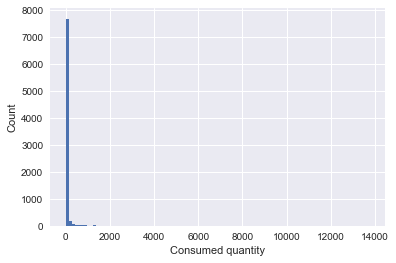

In [42]:
ax=enc_med_cl2_dropna['CONSUMED_QUANTITY'].hist(bins=100)
ax.set_xlabel('Consumed quantity')
ax.set_ylabel('Count')

Check the maximum value of consumed quantity

In [20]:
 enc_med_cl2.loc[enc_med_cl2_dropna['CONSUMED_QUANTITY'].idxmax()]

MEDICATION_ID                                  16980
NDC_CODE                                    74144304
INDEX_ID                                   323672947
ENCOUNTER_ID                                64555593
GENERIC_NAME                          norepinephrine
BRAND_NAME                       Levophed Bitartrate
PRODUCT_STRENGTH_DESCRIPTION                 1 mg/ml
MED_DISPENSED_CARESETTING_ID                     174
DISPENSED_CARESETTING_DESC                Not Mapped
DISCONTINUE_REASON_ID                             15
DISCONTINUE_REASON_DESC                    Manual DC
FREQUENCY_ID                                     111
FREQUENCY_DESC                                   NaN
ORDER_STOP_TYPE_ID                                 2
ORDER_STOP_TYPE_DESC                  Physician Stop
ORDER_TYPE_ID                                      4
ORDER_TYPE_DESC                                  NaN
MED_ORDER_STATUS_ID                                4
MED_ORDER_STATUS_DESC                   Discon

Text(0,0.5,'Counts')

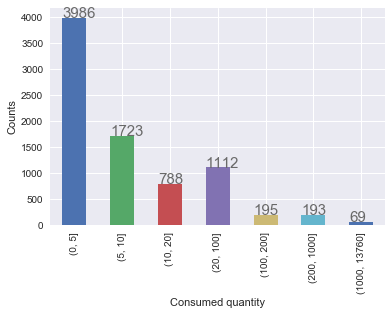

In [29]:
bins = [0, 5, 10, 20, 100, 200, 1000, 13760]
bins_counts = pd.cut(enc_med_cl2_dropna['CONSUMED_QUANTITY'], bins)
ax1 = pd.value_counts(bins_counts, sort=False).plot(kind='bar')
bar_annotation(ax1, 'number')
ax1.set_xlabel('Consumed quantity')
ax1.set_ylabel('Counts')

#### Consumed quantity > 1000

In [43]:
cq_over1000 = enc_med_cl2_dropna.query('CONSUMED_QUANTITY>1000')
print('The number of observations where consumed quantity > 1000: {}'.format(cq_over1000.shape[0]))

The number of observations where consumed quantity > 1000: 69


In [44]:
cq_over1000[['NDC_CODE', 'DOSE_QUANTITY', 'CONSUMED_QUANTITY',
             'ORDER_STRENGTH', 'ORDER_VOLUME', 'PRODUCT_STRENGTH_DESCRIPTION',
             'ROUTE_DESCRIPTION', 'TOTAL_DISPENSED_DOSES',
             'stop_start_gap']]

,NDC_CODE,DOSE_QUANTITY,CONSUMED_QUANTITY,ORDER_STRENGTH,ORDER_VOLUME,PRODUCT_STRENGTH_DESCRIPTION,ROUTE_DESCRIPTION,TOTAL_DISPENSED_DOSES,stop_start_gap
2609,409144304,8,1056,32.0,32.0,1 mg/ml,intravenous,66,71.983333
3262,24112302,8,1008,32.0,32.0,1 mg/ml,intravenous,71,248.500000
3435,74144304,4,1008,16.0,16.0,1 mg/ml,intravenous,126,214.250000
4112,74144304,16,2880,64.0,0.0,1 mg/ml,intravenous,90,24.900000
4114,74144304,4,1360,16.0,0.0,1 mg/ml,intravenous,170,69.716667
4124,74144304,4,2000,16.0,0.0,1 mg/ml,intravenous,250,83.683333
4125,74144304,16,13760,64.0,0.0,1 mg/ml,intravenous,430,233.683333
4134,74144304,4,2400,16.0,0.0,1 mg/ml,intravenous,300,122.666667
4147,74144304,16,2880,64.0,0.0,1 mg/ml,intravenous,90,91.500000
4156,74144304,4,2080,16.0,0.0,1 mg/ml,intravenous,260,281.583333


### Unit strength

In [46]:
enc_med_cl2_dropna[['UNIT_STRENGTH']].describe()

,UNIT_STRENGTH
count,8066.000000
mean,155.048391
std,270.009077
min,0.050000
25%,4.000000
50%,10.000000
75%,200.000000
max,1200.000000


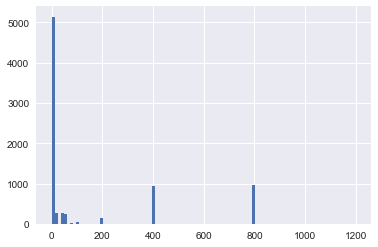

In [47]:
enc_med_cl2_dropna['UNIT_STRENGTH'].hist(bins=100)

Maximum

In [50]:
 enc_med_cl2.loc[enc_med_cl2_dropna['UNIT_STRENGTH'].idxmax()]

MEDICATION_ID                                         12894
NDC_CODE                                          517029925
INDEX_ID                                          135452555
ENCOUNTER_ID                                       62069536
GENERIC_NAME                                  phenylephrine
BRAND_NAME                      Phenylephrine Hydrochloride
PRODUCT_STRENGTH_DESCRIPTION                       10 mg/ml
MED_DISPENSED_CARESETTING_ID                            116
DISPENSED_CARESETTING_DESC                         Pharmacy
DISCONTINUE_REASON_ID                                    15
DISCONTINUE_REASON_DESC                           Manual DC
FREQUENCY_ID                                            110
FREQUENCY_DESC                                      X1 only
ORDER_STOP_TYPE_ID                                        2
ORDER_STOP_TYPE_DESC                         Physician Stop
ORDER_TYPE_ID                                             3
ORDER_TYPE_DESC                        M

We can infer that this unit strength is an error by looking at the concentration and order volume. 

Text(0,0.5,'Counts')

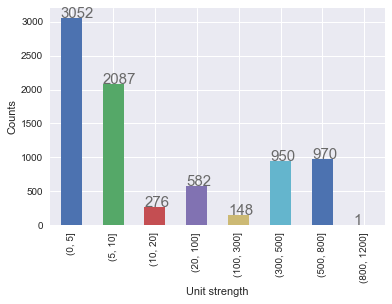

In [51]:
bins = [0, 5, 10, 20, 100, 300, 500, 800, 1200]
bins_counts = pd.cut(enc_med_cl2_dropna['UNIT_STRENGTH'], bins)
ax1 = pd.value_counts(bins_counts, sort=False).plot(kind='bar')
bar_annotation(ax1, 'number')
ax1.set_xlabel('Unit strength')
ax1.set_ylabel('Counts')

#### unit strength = 800. 

In [53]:
us_800 = enc_med_cl2_dropna.query('UNIT_STRENGTH == 800')
print('The number of observations where unit strength = 800: {}'.format(us_800.shape[0]))

The number of observations where unit strength = 800: 970


In [54]:
us_800[['NDC_CODE', 'DOSE_QUANTITY', 'CONSUMED_QUANTITY',
             'ORDER_STRENGTH', 'ORDER_VOLUME', 'PRODUCT_STRENGTH_DESCRIPTION',
             'ROUTE_DESCRIPTION', 'TOTAL_DISPENSED_DOSES',
             'stop_start_gap']]

,NDC_CODE,DOSE_QUANTITY,CONSUMED_QUANTITY,ORDER_STRENGTH,ORDER_VOLUME,PRODUCT_STRENGTH_DESCRIPTION,ROUTE_DESCRIPTION,TOTAL_DISPENSED_DOSES,stop_start_gap
0,517130525,1,7,800.0,NaN,160 mg/ml,intravenous,7,0.000000
1,517130525,1,10,800.0,5.0,160 mg/ml,intravenous,220,507.416667
2,517130525,1,7,800.0,NaN,160 mg/ml,intravenous,7,0.000000
3,517130525,1,7,800.0,NaN,160 mg/ml,intravenous,7,0.000000
11,74582010,1,24,800.0,500.0,40 mg/ml,intravenous,12,0.616667
362,409780924,1,5,800.0,500.0,5%-160 mg/100 ml,intravenous,5,20.916667
363,409780924,1,5,800.0,500.0,5%-160 mg/100 ml,intravenous,5,0.000000
364,409780924,1,5,800.0,500.0,5%-160 mg/100 ml,intravenous,5,0.000000
365,409780924,1,5,800.0,500.0,5%-160 mg/100 ml,intravenous,5,31.383333
366,409780924,1,5,800.0,500.0,5%-160 mg/100 ml,intravenous,5,0.000000


In [56]:
us_800[['CONSUMED_QUANTITY', 'TOTAL_DISPENSED_DOSES']].describe()

,CONSUMED_QUANTITY,TOTAL_DISPENSED_DOSES
count,970.000000,970.000000
mean,8.540206,7.347423
std,25.419878,18.363768
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,7.000000,7.000000
max,518.000000,259.000000


## Total consumed strength

In [59]:
enc_med_cl2_dropna[['TOTAL_CONSUMED_STRENGTH']].describe()

,TOTAL_CONSUMED_STRENGTH
count,8066.000000
mean,1858.121659
std,9888.570509
min,0.100000
25%,16.000000
50%,100.000000
75%,800.000000
max,414400.000000


Text(0,0.5,'Counts')

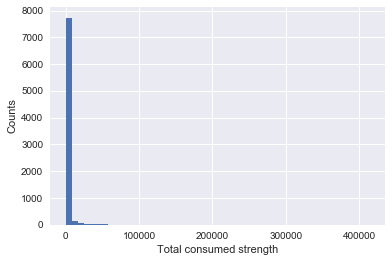

In [61]:
ax = enc_med_cl2_dropna['TOTAL_CONSUMED_STRENGTH'].hist(bins=50)
ax.set_xlabel('Total consumed strength')
ax.set_ylabel('Counts')

Maximum

In [63]:
 enc_med_cl2.loc[enc_med_cl2_dropna['TOTAL_CONSUMED_STRENGTH'].idxmax()]

MEDICATION_ID                                     28408
NDC_CODE                                       74781022
INDEX_ID                                      380570200
ENCOUNTER_ID                                   31149565
GENERIC_NAME                                   dopamine
BRAND_NAME                       Dopamine Hydrochloride
PRODUCT_STRENGTH_DESCRIPTION           5%-320 mg/100 ml
MED_DISPENSED_CARESETTING_ID                        116
DISPENSED_CARESETTING_DESC                     Pharmacy
DISCONTINUE_REASON_ID                                15
DISCONTINUE_REASON_DESC                       Manual DC
FREQUENCY_ID                                        111
FREQUENCY_DESC                                      NaN
ORDER_STOP_TYPE_ID                                    2
ORDER_STOP_TYPE_DESC                     Physician Stop
ORDER_TYPE_ID                                         2
ORDER_TYPE_DESC                 Large Volume Parenteral
MED_ORDER_STATUS_ID                             

Text(0,0.5,'Counts')

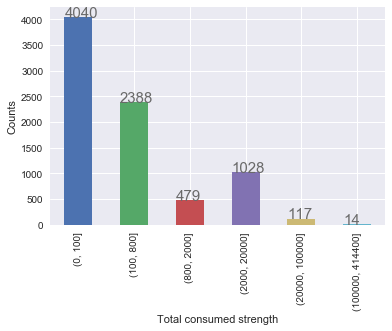

In [64]:
bins = [0, 100, 800, 2000, 20000, 100000, 414400]
bins_counts = pd.cut(enc_med_cl2_dropna['TOTAL_CONSUMED_STRENGTH'], bins)
ax1 = pd.value_counts(bins_counts, sort=False).plot(kind='bar')
bar_annotation(ax1, 'number')
ax1.set_xlabel('Total consumed strength')
ax1.set_ylabel('Counts')

In [65]:
tcs_over100000 = enc_med_cl2_dropna.query('TOTAL_CONSUMED_STRENGTH > 100000')
tcs_over100000[['NDC_CODE', 'DOSE_QUANTITY', 'CONSUMED_QUANTITY',
             'ORDER_STRENGTH', 'ORDER_VOLUME', 'PRODUCT_STRENGTH_DESCRIPTION',
             'ROUTE_DESCRIPTION', 'TOTAL_DISPENSED_DOSES',
             'stop_start_gap']]

,NDC_CODE,DOSE_QUANTITY,CONSUMED_QUANTITY,ORDER_STRENGTH,ORDER_VOLUME,PRODUCT_STRENGTH_DESCRIPTION,ROUTE_DESCRIPTION,TOTAL_DISPENSED_DOSES,stop_start_gap
218,409780922,1,336,400.0,250.0,5%-160 mg/100 ml,intravenous,336,297.050000
701,74780922,1,546,400.0,250.0,5%-160 mg/100 ml,intravenous,546,500.150000
863,338100702,1,420,400.0,250.0,5%-160 mg/100 ml,intravenous,210,44.250000
1438,74781022,1,518,800.0,10.0,5%-320 mg/100 ml,intravenous,259,288.400000
1614,74781022,1,168,800.0,10.0,5%-320 mg/100 ml,intravenous,84,149.333333
1644,74781022,1,140,800.0,10.0,5%-320 mg/100 ml,intravenous,70,248.383333
1671,74781022,1,252,800.0,10.0,5%-320 mg/100 ml,intravenous,126,101.866667
2199,338100902,1,140,800.0,250.0,5%-320 mg/100 ml,intravenous,140,127.150000
2217,338100902,1,189,800.0,250.0,5%-320 mg/100 ml,intravenous,189,205.116667
2242,338100902,1,203,800.0,250.0,5%-320 mg/100 ml,intravenous,203,170.083333


It seems consumed quantity is a multiple of the total dispensed doses